In [1]:
import pandas as pd
import boto3
import numpy as np
from collections import Counter
import os
import random

import re, string
from typing import Dict

import torch, torchtext
import torchvision.models as models
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import GloVe
from torch import nn, optim
from torch.nn import Module, Embedding, LSTM, RNN, GRU, Linear, Sequential, Dropout
from torch.nn.functional import sigmoid, relu, elu, tanh
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils.rnn import PackedSequence


from tqdm import tqdm

SEED = 1234
N_SAMPLES = 100_000

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

import time

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Today I'm going to use {device.type}")

Today I'm going to use cuda


In [4]:
chunks = pd.read_csv('../data/toxic_data.csv', chunksize=100000)
df = pd.concat(chunks)
df.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [5]:
df['comment_text'] = df['comment_text'].fillna("")
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['toxicity']:
    df.loc[:, col] = np.where(df[col] >= 0.5, True, False)

In [6]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] != 'train']

In [7]:
# sample = df
sample = train_df.sample(N_SAMPLES, random_state=SEED, ignore_index=True)
train_text, val_text, train_label, val_label = train_test_split(sample['comment_text'], sample['toxicity'], test_size=0.2, random_state=SEED)
# train_text, train_label = sample['comment_text'], sample['toxicity']
test_text, test_label = test_df['comment_text'], test_df['toxicity']

train_label = torch.tensor(train_label.values, dtype=torch.float32).to(device)
val_label = torch.tensor(val_label.values, dtype=torch.float32).to(device) 
test_label = torch.tensor(test_label.values, dtype=torch.float32).to(device) 

In [8]:
train_text.shape, val_text.shape, test_text.shape

((80000,), (20000,), (194641,))

In [9]:
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub('\d+', ' ', x)

In [10]:
# clean misspellings
train_text = train_text.apply(replace_typical_misspell)
val_text = val_text.apply(replace_typical_misspell)
test_text = test_text.apply(replace_typical_misspell)

# clean the text
train_text = train_text.apply(clean_text)
val_text = val_text.apply(clean_text)
test_text = test_text.apply(clean_text)

# clean numbers
train_text = train_text.apply(clean_numbers)
val_text = val_text.apply(clean_numbers)
test_text = test_text.apply(clean_numbers)

In [11]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line))
    
# Create a vocabulary with words seen at least 3 (min_freq) times
vocab = torchtext.vocab.vocab(counter, min_freq=3)

In [12]:
# Add the unknown token and use it by default for unknown words
unk_token = '<unk>'
# vocab.insert_token(unk_token, 0)
vocab.set_default_index(0)

# Add the pad token Explanation https://huggingface.co/docs/transformers/pad_truncation
pad_token = '<pad>'
vocab.insert_token(pad_token, 1)

In [13]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [14]:
#save vocab
torch.save(vocab, 'vocab_obj_pytorch.pth')

In [15]:
print(f"Before transform:\n{train_text.iloc[1666]}")
print(f"After transform:\n{text_transform_pipeline(train_text.iloc[1666])}")

Before transform:
The part that is always difficult to take is when the Globe criticizes Trump with such indignation  .  
  .  
As if anybody has forgotten that this is the same Globe that was a serial enabler of Stephen Harper  .  
  .  
Not once  ,  
Not twice  ,  
Not three times  ,  
  .  
But yes  ,   four times in a row  !  
  .  
Talk about motes and beams  .    .    .  
  .  
Glad to see the Globe has got it right on Trump  ,   for sure  ,   but  ,   nonetheless  ,   the whole thing reeks of hypocrisy  .  
After transform:
[21, 1186, 0, 2, 161, 1496, 93, 622, 2, 37, 21, 884, 10015, 113, 320, 57, 10016, 26, 26, 45, 109, 3517, 722, 7984, 0, 65, 2, 21, 473, 884, 0, 87, 41, 10017, 7990, 6, 2122, 2096, 26, 26, 111, 1440, 44, 111, 4484, 44, 111, 392, 1615, 44, 26, 176, 760, 44, 2795, 1615, 180, 41, 2261, 36, 26, 1247, 155, 0, 10, 10018, 26, 26, 26, 26, 5310, 93, 47, 21, 884, 722, 1917, 34, 385, 20, 113, 44, 112, 883, 44, 176, 44, 3865, 44, 21, 1576, 207, 8103, 6, 1273, 26]


In [16]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

In [17]:
#PARAMETERS
N_EPOCHES = 10
max_len = 100
batch_size = 128

# Size of the state vectors
lstm_hiden_size = 128
dense_hiden_size = 4 * lstm_hiden_size

# General NN training parameters
learning_rate = 0.0001

In [18]:
# Create data loaders
train_dataset = TensorDataset(
    transformText(train_text, max_len), train_label
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(transformText(val_text, max_len), val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(transformText(test_text, max_len), test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_2173/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


In [19]:
#Pretrained Word Embeddings ====> GloVe, FastText, CharNGram
#Let us try GloVe

glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

In [20]:
embedding_matrix.shape

torch.Size([31203, 300])

In [21]:
# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())
vocab_size

31203

In [22]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, lstm_hiden_size, dense_hiden_size):
        super(NeuralNet, self).__init__()
        max_features = embedding_matrix.shape[0]
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(embedding_matrix.clone().detach())
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.6)

        self.lstm1 = nn.LSTM(embed_size, lstm_hiden_size, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hiden_size * 2, lstm_hiden_size, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(dense_hiden_size, dense_hiden_size)
        self.linear2 = nn.Linear(dense_hiden_size, dense_hiden_size)
        
        self.linear_out = nn.Linear(dense_hiden_size, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = relu(self.linear1(h_conc))
        h_conc_linear2  = relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2       
        result = self.linear_out(hidden)

        return result

In [23]:
model = NeuralNet(embedding_matrix, lstm_hiden_size, dense_hiden_size)
# Setting our trainer
trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
cross_ent_loss = nn.BCEWithLogitsLoss(reduction='mean')

In [24]:
train_losses = []
val_losses = []
train_scores = []
val_scores = []

# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(N_EPOCHES):
    start = time.time()
    training_loss = 0
    val_loss = 0
    train_score = 0
    val_score = 0
    model.train()

    for data, target in tqdm(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = cross_ent_loss(output.squeeze(1), target)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        training_loss += loss.item()
        train_score += roc_auc_score(target.cpu(), output.detach().cpu().numpy())
        
        
    model.eval()
    
    for data, target in tqdm(val_loader):
        data = data.to(device)
        target = target.to(device)
        val_predictions = torch.sigmoid(model(data)).squeeze(1)
        loss = cross_ent_loss(val_predictions, target)
        val_loss += loss.item()
        val_score += roc_auc_score(target.cpu(), val_predictions.detach().cpu().numpy())
        
    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    train_score = train_score / len(train_label)
    val_score = val_score / len(val_label)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Validation_loss {val_loss}. Seconds {end-start}"
    )

100%|██████████| 157/157 [00:01<00:00, 97.92it/s]


Epoch 0. Train_loss 0.0020916143033653497. Validation_loss 0.0055397647827863696. Seconds 19.08381676673889


100%|██████████| 157/157 [00:01<00:00, 97.71it/s]


Epoch 1. Train_loss 0.0015559670167975127. Validation_loss 0.005519388055801391. Seconds 19.310235500335693


100%|██████████| 157/157 [00:01<00:00, 96.62it/s]


Epoch 2. Train_loss 0.0014673158599063753. Validation_loss 0.005513332599401474. Seconds 19.394148111343384


100%|██████████| 157/157 [00:01<00:00, 95.63it/s]


Epoch 3. Train_loss 0.0014407314858399332. Validation_loss 0.005516001254320144. Seconds 19.75512719154358


100%|██████████| 157/157 [00:01<00:00, 95.12it/s]


Epoch 4. Train_loss 0.0014102384057827293. Validation_loss 0.00551564888060093. Seconds 19.947484731674194


100%|██████████| 157/157 [00:01<00:00, 94.00it/s]


Epoch 5. Train_loss 0.0013745558459311723. Validation_loss 0.005500232550501824. Seconds 20.135973691940308


100%|██████████| 157/157 [00:01<00:00, 93.66it/s]


Epoch 6. Train_loss 0.0013570940275210888. Validation_loss 0.005495200988650322. Seconds 20.322299242019653


100%|██████████| 157/157 [00:01<00:00, 93.17it/s]


Epoch 7. Train_loss 0.0013331962434574962. Validation_loss 0.005490875974297524. Seconds 20.3884174823761


100%|██████████| 157/157 [00:01<00:00, 92.15it/s]


Epoch 8. Train_loss 0.001310966149996966. Validation_loss 0.005490161684155464. Seconds 20.58425760269165


100%|██████████| 157/157 [00:01<00:00, 91.62it/s]

Epoch 9. Train_loss 0.0012882645259145646. Validation_loss 0.005504746806621551. Seconds 20.722145080566406


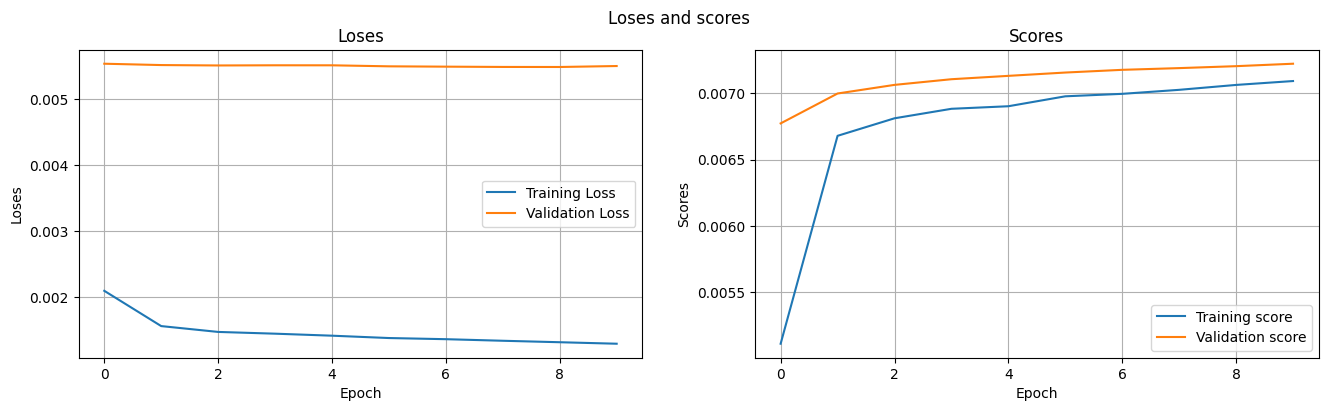

In [25]:
plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Loses and scores')
ax[0].plot(train_losses, label="Training Loss")
ax[0].plot(val_losses, label="Validation Loss")
ax[0].legend()
ax[0].set_title('Loses')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loses")
ax[1].plot(train_scores, label="Training score")
ax[1].plot(val_scores, label="Validation score")
ax[1].legend()
ax[1].set_title('Scores')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Scores")
plt.show()

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()
test_predictions = []
for data, target in tqdm(test_loader):
    test_preds = model(data.to(device))
    test_predictions.extend(
        [sigmoid(test_pred[0]) for test_pred in test_preds.detach().cpu().numpy()]
    )

100%|██████████| 1521/1521 [00:15<00:00, 96.68it/s]


In [27]:
sum(test_predictions), len(test_predictions)
oof_name = 'predicted_target'
test_df[oof_name] = test_predictions

In [28]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, oof_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[oof_name])

def compute_bpsn_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bnsp_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, oof_name, 'toxicity')
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,1065,0.744374,0.688865,0.959133
6,black,1519,0.744557,0.751014,0.945925
7,white,2452,0.764248,0.731693,0.956448
5,muslim,2040,0.777276,0.773808,0.943169
8,psychiatric_or_mental_illness,511,0.826520,0.863479,0.913869
4,jewish,835,0.833136,0.833654,0.938306
1,female,5155,0.850737,0.857222,0.930564
0,male,4386,0.860066,0.845110,0.941385
3,christian,4226,0.877651,0.897850,0.915248


In [29]:
def calculate_overall_auc(df, oof_name):
    true_labels = df['toxicity']
    predicted_labels = df[oof_name]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
FINAL_SCORE = get_final_metric(bias_metrics_df, calculate_overall_auc(test_df, oof_name))
print(f"FINAL SCORE IS {FINAL_SCORE}")

FINAL SCORE IS 0.8626814431673094
